# CIFAR-100


## 一、构造


In [1]:
import warnings

warnings.filterwarnings("ignore")

## 二、验证


In [1]:
!pwd
!tree ../data/cifar-100/gen/

/nvme/szh/code/tta-mr/result_analysis
../data/cifar-100/gen/
├── aux_data.npy
├── aux_label.npy
├── inc_data.npy
├── inc_label.npy
├── nr_0.0_nt_asymmetric_cvpr
│   ├── train_clean_data.npy
│   ├── train_clean_label.npy
│   ├── train_noisy_data.npy
│   ├── train_noisy_label.npy
│   └── train_noisy_true_label.npy
├── nr_0.1_nt_asymmetric_cvpr
│   ├── train_clean_data.npy
│   ├── train_clean_label.npy
│   ├── train_noisy_data.npy
│   ├── train_noisy_label.npy
│   └── train_noisy_true_label.npy
├── nr_0.25_nt_asymmetric_cvpr
│   ├── train_clean_data.npy
│   ├── train_clean_label.npy
│   ├── train_noisy_data.npy
│   ├── train_noisy_label.npy
│   └── train_noisy_true_label.npy
├── nr_0.5_nt_asymmetric_cvpr
│   ├── train_clean_data.npy
│   ├── train_clean_label.npy
│   ├── train_noisy_data.npy
│   ├── train_noisy_label.npy
│   └── train_noisy_true_label.npy
├── nr_0.75_nt_asymmetric_cvpr
│   ├── train_clean_data.npy
│   ├── train_clean_label.npy
│   ├── train_noisy_data.npy
│   ├── train_noi

In [1]:
!tree ../ckpt/cifar-10/

../ckpt/cifar-10/
├── nr_0.2_nt_symmetric
│   └── step_0
│       └── contra
│           └── cifar-resnet18_worker_restore.pth
├── nr_0.2_nt_symmetric_balanced
│   ├── pretrain
│   │   └── step_0
│   │       └── cifar-resnet18_worker_restore.pth
│   ├── step_0
│   │   ├── cifar-resnet18_teacher_restore.pth
│   │   ├── cifar-resnet18_worker_restore.pth
│   │   ├── contra
│   │   │   ├── cifar-resnet18_teacher_restore.pth
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── coteaching
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── coteaching_plus
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── cotta
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── jocor
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── plf
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   ├── raw
│   │   │   └── cifar-resnet18_worker_restore.pth
│   │   └── replay
│   │       └── cifar-resnet18_worker_restore.pth
│   ├── step_1
│   │   ├── cifar-resnet

### 公共函数


In [2]:
# 函数用于加载每个版本的 D_tr 数据集
def load_d_tr(version, base_dir):
    data_path = os.path.join(base_dir, f"step_{version}", "train_data.npy")
    labels_path = os.path.join(base_dir, f"step_{version}", "train_label.npy")

    data = np.load(data_path)
    labels = np.load(labels_path)

    # 验证数据形状和标签范围
    print(f"版本 {version}:")
    print(f"数据形状: {data.shape}, 标签形状: {labels.shape}")
    print(f"标签唯一值: {np.unique(labels)}")

    return data, labels

### 标签分布


验证 base_dir 数据集:
版本 0:
数据形状: (25000, 3, 32, 32), 标签形状: (25000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
版本 1:
数据形状: (12500, 3, 32, 32), 标签形状: (12500,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 80 82 83 89 90 91 92 95]
版本 2:
数据形状: (10000, 3, 32, 32), 标签形状: (10000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 80 82 83 89 90 91 92 95]
版

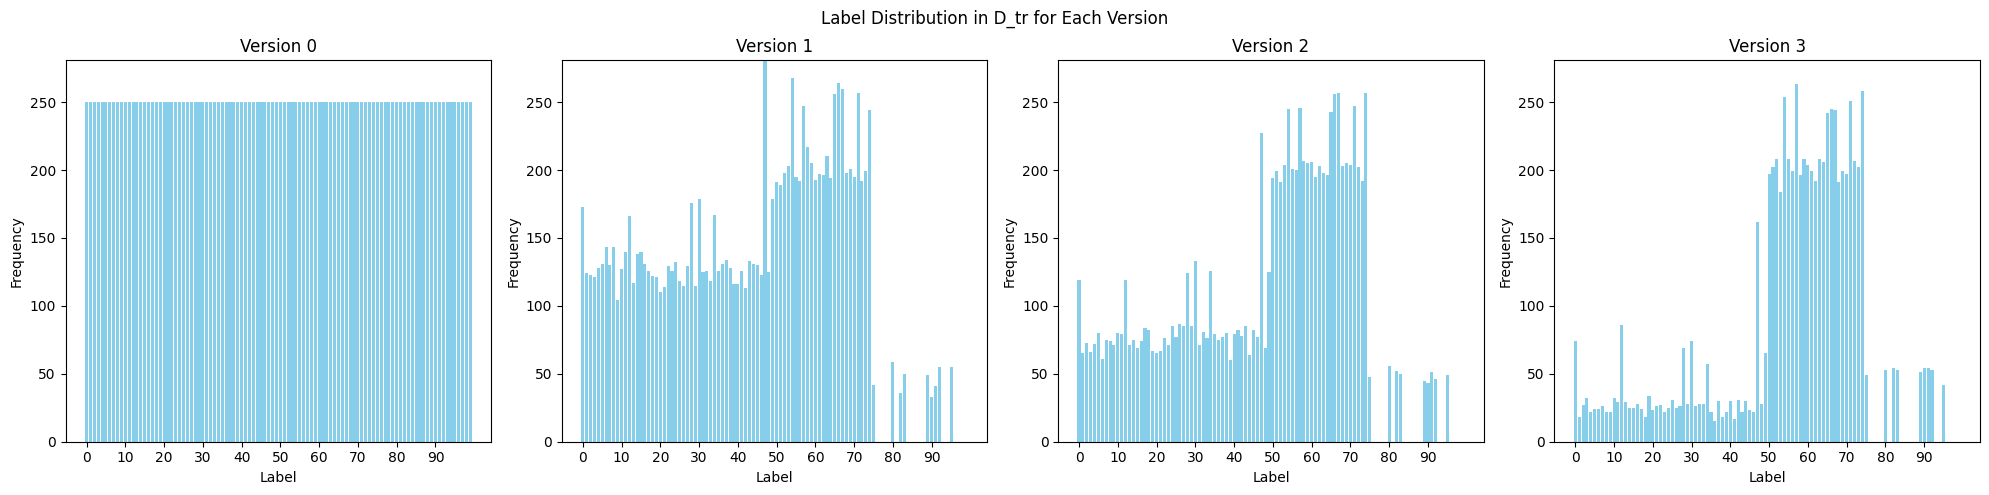

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# 设置增量版本和类的数量
num_versions = 4  # 在 CIFAR-100 生成的数据集中有 4 个版本
num_classes = 100  # CIFAR-100 共有 100 个类


# 验证每个版本 D_tr 的标签分布变化并统一纵坐标
def plot_label_distribution(base_dir):
    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(20, 5))
    fig.suptitle("Label Distribution in D_tr for Each Version")

    max_count = 0  # 初始化最大频率值

    # 计算所有版本中的最大频率值
    for version in range(num_versions):
        _, labels = load_d_tr(version, base_dir)
        _, counts = np.unique(labels, return_counts=True)
        max_count = max(max_count, max(counts))

    # 绘图并设置统一的纵坐标
    for version in range(num_versions):
        _, labels = load_d_tr(version, base_dir)
        unique, counts = np.unique(labels, return_counts=True)

        # 为了保持 x 轴一致，确保横坐标是从 0 到 99（共100个类）
        full_counts = np.zeros(num_classes)
        full_counts[unique] = counts  # 填充实际的计数值

        axs[version].bar(range(num_classes), full_counts, color="skyblue")
        axs[version].set_title(f"Version {version}")
        axs[version].set_xlabel("Label")
        axs[version].set_ylabel("Frequency")
        axs[version].set_xticks(
            range(0, num_classes, 10)
        )  # 保证横轴一致，每隔 10 个类显示一次
        axs[version].set_ylim(0, max_count)  # 设置统一的纵坐标最大值

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)  # 调整顶部以避免标题与图形重叠
    plt.show()


# 定义数据集的路径
base_dir = "../data/cifar-100/gen/nr_0.2_nt_asymmetric_balanced"
print("验证 base_dir 数据集:")
plot_label_distribution(base_dir)

### 2、验证噪声


In [3]:
!ls ../gen_dataset/

cifar-100_asymmetric_0.1_asymmetric_noisy_classes_detailed.json
cifar-100_asymmetric_0.1_asymmetric_noisy_classes_simple.json
cifar-100_asymmetric_0.2_asymmetric_noisy_classes_detailed.json
cifar-100_asymmetric_0.2_asymmetric_noisy_classes_simple.json
cifar-100_asymmetric_0.3_asymmetric_noisy_classes_detailed.json
cifar-100_asymmetric_0.3_asymmetric_noisy_classes_simple.json
cifar-100_asymmetric_0.5_asymmetric_noisy_classes_detailed.json
cifar-100_asymmetric_0.5_asymmetric_noisy_classes_simple.json
cifar-10-symmetric-0.1-symmetric_noisy_classes_detailed.json
cifar-10-symmetric-0.1-symmetric_noisy_classes_simple.json
cifar-10-symmetric-0.2-symmetric_noisy_classes_detailed.json
cifar-10-symmetric-0.2-symmetric_noisy_classes_simple.json
cifar-10-symmetric-0.3-symmetric_noisy_classes_detailed.json
cifar-10-symmetric-0.3-symmetric_noisy_classes_simple.json
cifar-10-symmetric-0.5-symmetric_noisy_classes_detailed.json
cifar-10-symmetric-0.5-symmetric_noisy_classes_simple.json
data
gen_cifar10

验证 base_dir 数据集:
版本 0:
数据形状: (25000, 3, 32, 32), 标签形状: (25000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
版本 1:
数据形状: (12500, 3, 32, 32), 标签形状: (12500,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 80 82 83 89 90 91 92 95]
版本 2:
数据形状: (10000, 3, 32, 32), 标签形状: (10000,)
标签唯一值: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 80 82 83 89 90 91 92 95]
版

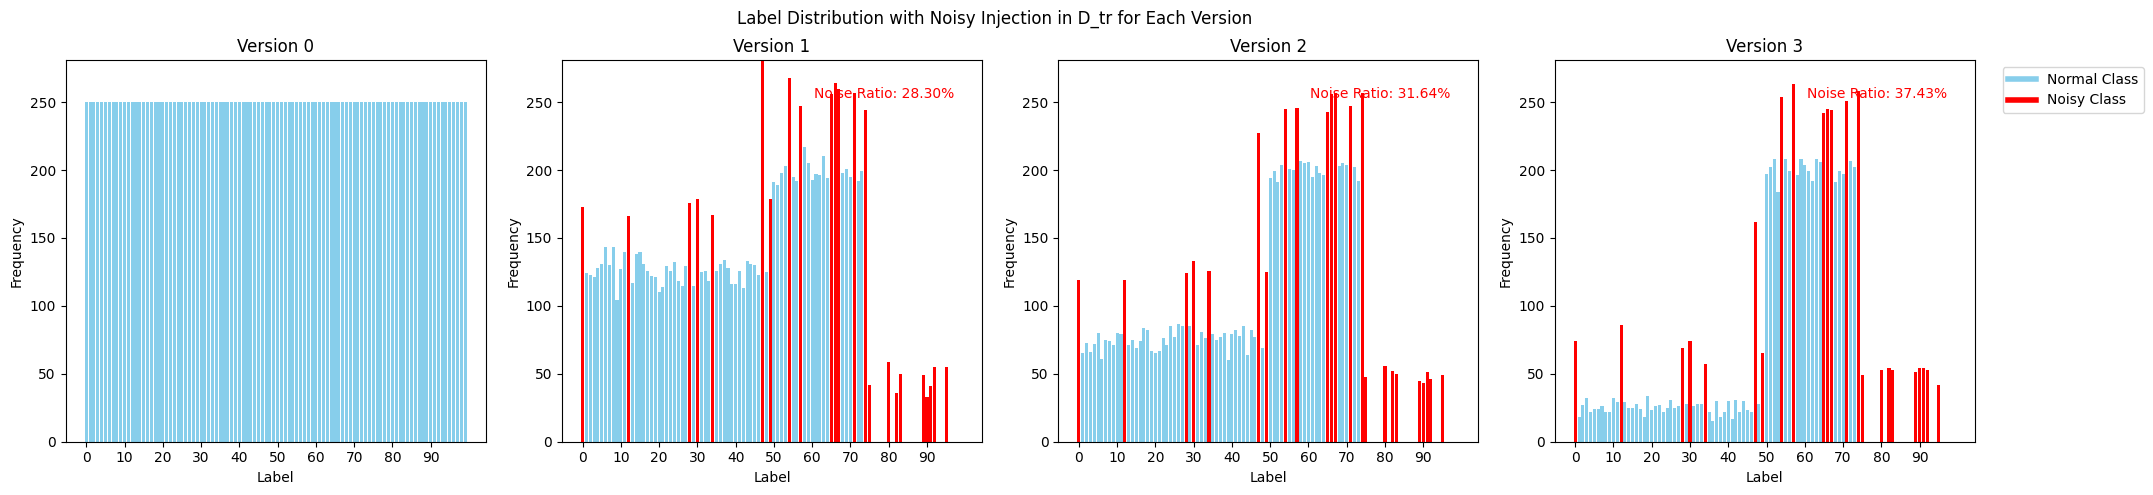

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import json

# 设置增量版本和类的数量
num_versions = 4  # 在 CIFAR-100 生成的数据集中有 4 个版本
num_classes = 100  # CIFAR-100 共有 100 个类


# 分析和验证噪声注入
# 从导出的 json 文件加载噪声映射关系
def load_noisy_mapping(json_file_path):
    with open(json_file_path, "r") as f:
        noisy_mapping = json.load(f)
    return noisy_mapping


# 验证噪声注入的标签分布
def plot_noisy_label_distribution(base_dir, noisy_json_path):
    noisy_mapping = load_noisy_mapping(noisy_json_path)

    plt.style.use("default")
    fig, axs = plt.subplots(1, num_versions, figsize=(20, 5))
    fig.suptitle("Label Distribution with Noisy Injection in D_tr for Each Version")

    max_count = 0  # 初始化最大频率值

    # 计算所有版本中的最大频率值
    for version in range(num_versions):
        _, labels = load_d_tr(version, base_dir)
        _, counts = np.unique(labels, return_counts=True)
        max_count = max(max_count, max(counts))

    # 绘图并设置统一的纵坐标
    for version in range(num_versions):
        _, labels = load_d_tr(version, base_dir)
        unique, counts = np.unique(labels, return_counts=True)

        # 为了保持 x 轴一致，确保横坐标是从 0 到 99（共100个类）
        full_counts = np.zeros(num_classes)
        full_counts[unique] = counts  # 填充实际的计数值

        # 标注噪声标签
        noisy_labels = set()
        for mapping in noisy_mapping:
            noisy_labels.add(mapping[1])

        if version == 0:
            # 初始版本没有注入噪声，用单一颜色显示
            colors = ["skyblue" for label in range(num_classes)]
        else:
            # 其他版本用不同颜色标记噪声标签
            colors = []
            for label in range(num_classes):
                if label in unique:
                    colors.append("red" if label in noisy_labels else "skyblue")
                else:
                    colors.append("skyblue")

        axs[version].bar(range(num_classes), full_counts, color=colors)
        axs[version].set_title(f"Version {version}")
        axs[version].set_xlabel("Label")
        axs[version].set_ylabel("Frequency")
        axs[version].set_xticks(range(0, num_classes, 10))  # 保证横轴一致
        axs[version].set_ylim(0, max_count)  # 设置统一的纵坐标最大值

        # 添加噪声比例注释，仅在版本 1 到 3 中添加
        if version > 0:
            noisy_count = sum(
                [
                    counts[np.where(unique == label)[0][0]]
                    for label in noisy_labels
                    if label in unique
                ]
            )
            total_count = sum(counts)
            noise_ratio = noisy_count / total_count if total_count > 0 else 0
            axs[version].annotate(
                f"Noise Ratio: {noise_ratio:.2%}",
                xy=(0.6, 0.9),
                xycoords="axes fraction",
                fontsize=10,
                color="red",
            )

    plt.tight_layout()
    fig.subplots_adjust(top=0.88)  # 调整顶部以避免标题与图形重叠
    plt.legend(
        handles=[
            plt.Line2D([0], [0], color="skyblue", lw=4, label="Normal Class"),
            plt.Line2D([0], [0], color="red", lw=4, label="Noisy Class"),
        ],
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )
    plt.show()


# 定义数据集的路径和噪声映射文件路径
base_dir = "../data/cifar-100/gen/nr_0.2_nt_asymmetric_balanced"
noisy_json_path = (
    "../gen_dataset/cifar-100_asymmetric_0.2_asymmetric_noisy_classes_simple.json"
)

print("验证 base_dir 数据集:")
# plot_label_distribution(base_dir)
# plot_forgotten_classes_analysis(base_dir)
plot_noisy_label_distribution(base_dir, noisy_json_path)

1. **版本 0**：

   - 版本 0 中的标签分布是相对均匀的，各个类的频率大致相同。
   - 图中以红色显示的标签是被标记为噪声的类别。在初始版本中，这些类别均被标注为噪声（虽然噪声还未注入），以便之后的版本中进行替换。

2. **版本 1、2 和 3**：

   - **噪声注入后的变化**：

     - 在版本 1、2 和 3 中，可以看到红色的噪声类开始出现较高的频率，表明这些类别的样本数量增加了，符合噪声注入的预期。
     - 在这些版本中，噪声样本的引入导致某些类别（以红色显示）数量显著增多，而其他类别的频率有所下降。这表明某些类的标签被替换为噪声类。

   - **逐版本变化**：
     - 从版本 1 到版本 3，可以观察到噪声类的样本频率逐步增加，而正常类的样本数量逐步减少。这符合噪声比例逐渐增大的设定，即随着版本的增加，更多的样本被注入噪声，导致噪声类的占比不断上升。

3. **说明**

- **噪声标记与颜色显示**：

  - 红色用于标记被注入噪声的类别，这些类别的数量逐渐增多，符合噪声注入的逻辑。
  - 每个版本的噪声类与正常类之间的颜色对比（红色 vs. 蓝色）明确区分了哪些类受到了噪声注入，帮助理解噪声的影响范围。

- **噪声比例的变化**：
  - 噪声类的增加呈现出累积的效果，表明在每个增量版本中，有更多的样本被替换为噪声类。这种变化趋势符合代码逻辑中逐版本增加噪声比例的设计目标。


# Get classes


pet-37


In [2]:
from torchvision import datasets


data_dir = "../data/pet-37/normal/oxford-pets"


# 加载 PET-37 数据集
train_dataset = datasets.OxfordIIITPet(
    root=data_dir,
    download=False,
)
test_dataset = datasets.OxfordIIITPet(root=data_dir, split="test", download=False)


# 获取类别名称列表
classes = train_dataset.classes

# 打印类别及其对应的标签序号
for i, class_name in enumerate(classes):
    print(f"Class {i}: {class_name}")

Class 0: Abyssinian
Class 1: American Bulldog
Class 2: American Pit Bull Terrier
Class 3: Basset Hound
Class 4: Beagle
Class 5: Bengal
Class 6: Birman
Class 7: Bombay
Class 8: Boxer
Class 9: British Shorthair
Class 10: Chihuahua
Class 11: Egyptian Mau
Class 12: English Cocker Spaniel
Class 13: English Setter
Class 14: German Shorthaired
Class 15: Great Pyrenees
Class 16: Havanese
Class 17: Japanese Chin
Class 18: Keeshond
Class 19: Leonberger
Class 20: Maine Coon
Class 21: Miniature Pinscher
Class 22: Newfoundland
Class 23: Persian
Class 24: Pomeranian
Class 25: Pug
Class 26: Ragdoll
Class 27: Russian Blue
Class 28: Saint Bernard
Class 29: Samoyed
Class 30: Scottish Terrier
Class 31: Shiba Inu
Class 32: Siamese
Class 33: Sphynx
Class 34: Staffordshire Bull Terrier
Class 35: Wheaten Terrier
Class 36: Yorkshire Terrier


cifar-10


In [3]:
from torchvision import datasets

# 加载 CIFAR-10 数据集
cifar10_dataset = datasets.CIFAR10(
    root="../../dataset/cifar-10/", train=True, download=True
)

# 获取类别名称列表
cifar10_classes = cifar10_dataset.classes

# 打印类别及其对应的标签序号
for i, class_name in enumerate(cifar10_classes):
    print(f"Class {i}: {class_name}")

Files already downloaded and verified
Class 0: airplane
Class 1: automobile
Class 2: bird
Class 3: cat
Class 4: deer
Class 5: dog
Class 6: frog
Class 7: horse
Class 8: ship
Class 9: truck


cifar100


In [4]:
from torchvision import datasets

# 加载 CIFAR-100 数据集
cifar100_dataset = datasets.CIFAR100(
    root="../../dataset/cifar-100/", train=True, download=True
)

# 获取类别名称列表
cifar100_classes = cifar100_dataset.classes

# 打印类别及其对应的标签序号
for i, class_name in enumerate(cifar100_classes):
    print(f"Class {i}: {class_name}")

Files already downloaded and verified
Class 0: apple
Class 1: aquarium_fish
Class 2: baby
Class 3: bear
Class 4: beaver
Class 5: bed
Class 6: bee
Class 7: beetle
Class 8: bicycle
Class 9: bottle
Class 10: bowl
Class 11: boy
Class 12: bridge
Class 13: bus
Class 14: butterfly
Class 15: camel
Class 16: can
Class 17: castle
Class 18: caterpillar
Class 19: cattle
Class 20: chair
Class 21: chimpanzee
Class 22: clock
Class 23: cloud
Class 24: cockroach
Class 25: couch
Class 26: crab
Class 27: crocodile
Class 28: cup
Class 29: dinosaur
Class 30: dolphin
Class 31: elephant
Class 32: flatfish
Class 33: forest
Class 34: fox
Class 35: girl
Class 36: hamster
Class 37: house
Class 38: kangaroo
Class 39: keyboard
Class 40: lamp
Class 41: lawn_mower
Class 42: leopard
Class 43: lion
Class 44: lizard
Class 45: lobster
Class 46: man
Class 47: maple_tree
Class 48: motorcycle
Class 49: mountain
Class 50: mouse
Class 51: mushroom
Class 52: oak_tree
Class 53: orange
Class 54: orchid
Class 55: otter
Class 56:

In [5]:
import json
from collections import defaultdict


def load_classes_from_file(file_path):
    """从文件中读取 CIFAR-100 的类别"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes


def load_mapping_from_json(file_path):
    """从JSON文件中加载 CIFAR-100 的 superclass 和 child class 的映射"""
    with open(file_path, "r") as f:
        mapping = json.load(f)
    return mapping


def validate_cifar100_mapping(classes_file, mapping_file):
    # 加载类别和映射数据
    cifar_classes = load_classes_from_file(classes_file)
    cifar_mapping = load_mapping_from_json(mapping_file)

    # 用于跟踪每个类别出现在哪些 superclass 中
    class_superclass_map = defaultdict(list)

    # 检查所有类别是否都存在于映射中
    all_mapped_classes = set()
    for superclass, child_classes in cifar_mapping.items():
        for cls in child_classes:
            class_superclass_map[cls].append(superclass)
            all_mapped_classes.add(cls)

    # 未被映射的类
    unmapped_classes = set(cifar_classes) - all_mapped_classes
    if unmapped_classes:
        print("以下类别未在映射中找到：")
        for cls in unmapped_classes:
            print(f" - {cls}")
    else:
        print("所有类别都在映射中找到了对应的 superclass。")

    # 检查是否有重复映射的类别
    duplicated_classes = [
        cls
        for cls, superclasses in class_superclass_map.items()
        if len(superclasses) > 1
    ]
    if duplicated_classes:
        print("\n存在重复映射的类别：")
        for cls in duplicated_classes:
            print(f" - {cls} 出现在超级类: {', '.join(class_superclass_map[cls])}")
    else:
        print("\n没有重复映射的类别。")

    # 打印每个 superclass 及其对应的 child classes
    for superclass, child_classes in cifar_mapping.items():
        print(f"\nSuperclass: {superclass}")
        print(f"Child Classes: {', '.join(child_classes)}")


if __name__ == "__main__":
    # 文件路径
    classes_file = "../configs/classes/cifar_100_classes.txt"
    mapping_file = "../configs/classes/cifar_100_mapping.json"

    # 验证映射
    validate_cifar100_mapping(classes_file, mapping_file)

所有类别都在映射中找到了对应的 superclass。

没有重复映射的类别。

Superclass: aquatic mammals
Child Classes: beaver, dolphin, otter, seal, whale

Superclass: fish
Child Classes: aquarium_fish, flatfish, ray, shark, trout

Superclass: flowers
Child Classes: orchid, poppy, rose, sunflower, tulip

Superclass: food containers
Child Classes: bottle, bowl, can, cup, plate

Superclass: fruit and vegetables
Child Classes: apple, mushroom, orange, pear, sweet_pepper

Superclass: household electrical devices
Child Classes: clock, keyboard, lamp, telephone, television

Superclass: household furniture
Child Classes: bed, chair, couch, table, wardrobe

Superclass: insects
Child Classes: bee, beetle, butterfly, caterpillar, cockroach

Superclass: large carnivores
Child Classes: bear, leopard, lion, tiger, wolf

Superclass: large man-made outdoor things
Child Classes: bridge, castle, house, road, skyscraper

Superclass: large natural outdoor scenes
Child Classes: cloud, forest, mountain, plain, sea

Superclass: large omnivor

food101


In [21]:
import json
from collections import defaultdict


def load_classes_from_file(file_path):
    """从文件中读取 food_101_classes.txt 中的类别"""
    with open(file_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
    return classes


def load_mapping_from_json(file_path):
    """从JSON文件中加载 food_101 的 superclass 和 child class 的映射"""
    with open(file_path, "r") as f:
        mapping = json.load(f)
    return mapping


def validate_food101_mapping(classes_file, mapping_file):
    # 加载类别和映射数据
    food_classes = load_classes_from_file(classes_file)
    food_mapping = load_mapping_from_json(mapping_file)

    # 用于跟踪每个类别出现在哪些 superclass 中
    class_superclass_map = defaultdict(list)

    # 检查所有类别是否都存在于映射中
    all_mapped_classes = set()
    for superclass, child_classes in food_mapping.items():
        for cls in child_classes:
            class_superclass_map[cls].append(superclass)
            all_mapped_classes.add(cls)

    # 未被映射的类
    unmapped_classes = set(food_classes) - all_mapped_classes
    if unmapped_classes:
        print("以下类别未在映射中找到：")
        for cls in unmapped_classes:
            print(f" - {cls}")
    else:
        print("所有类别都在映射中找到了对应的 superclass。")

    # 检查是否有重复映射的类别
    duplicated_classes = [
        cls
        for cls, superclasses in class_superclass_map.items()
        if len(superclasses) > 1
    ]
    if duplicated_classes:
        print("\n存在重复映射的类别：")
        for cls in duplicated_classes:
            print(f" - {cls} 出现在超级类: {', '.join(class_superclass_map[cls])}")
    else:
        print("\n没有重复映射的类别。")

    # 打印每个 superclass 及其对应的 child classes
    for superclass, child_classes in food_mapping.items():
        print(f"\nSuperclass: {superclass}")
        print(f"Child Classes: {', '.join(child_classes)}")


# 文件路径
classes_file = "../configs/classes/food_101_classes.txt"
mapping_file = "../configs/classes/food_101_mapping.json"

# 验证映射
validate_food101_mapping(classes_file, mapping_file)

所有类别都在映射中找到了对应的 superclass。

没有重复映射的类别。

Superclass: desserts
Child Classes: apple_pie, baklava, beignets, bread_pudding, carrot_cake, cheesecake, chocolate_cake, chocolate_mousse, churros, cup_cakes, donuts, frozen_yogurt, macarons, panna_cotta, red_velvet_cake, strawberry_shortcake, tiramisu, cannoli, creme_brulee, ice_cream

Superclass: salads
Child Classes: beet_salad, caesar_salad, caprese_salad, greek_salad, seaweed_salad

Superclass: sandwiches
Child Classes: breakfast_burrito, club_sandwich, croque_madame, grilled_cheese_sandwich, hamburger, hot_dog, lobster_roll_sandwich, pulled_pork_sandwich

Superclass: meat_dishes
Child Classes: baby_back_ribs, beef_carpaccio, beef_tartare, chicken_curry, chicken_quesadilla, chicken_wings, filet_mignon, foie_gras, fried_chicken, pork_chop, prime_rib, steak

Superclass: seafood
Child Classes: crab_cakes, clam_chowder, fish_and_chips, fried_calamari, grilled_salmon, lobster_bisque, mussels, oysters, scallops, shrimp_and_grits, sushi, sashimi,